In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from cmcrameri import cm
from matplotlib.lines import Line2D
from matplotlib.colors import to_hex
from scipy.stats import gaussian_kde

from pqcd.utils import (
    rcparams,
    to_nucleons_per_cubic_femtometre,
    nsat
)
plt.rcParams.update(rcparams)

In [2]:
collated_eos_path = [
    '../data/collated_np_all_post.csv', 
    '/home/isaac.legred/PTAnalysis/Analysis/collated_np_all_post.csv'
    ][0]

eos_dir = ['../data/eos-draws-default', '/home/philippe.landry/nseos/eos/gp/mrgagn'][0]

In [3]:
# Load the collated EOSs and filter out the ones with zero weight
collated_eos = pd.read_csv(collated_eos_path)
nonzero_collated_eos = collated_eos[collated_eos.logweight_total > -np.inf]

# The central density for which the mass reaches a maximum Mmax
ntov_array = to_nucleons_per_cubic_femtometre(nonzero_collated_eos['rhoc(M@Mmax)'])

# We can only apply the conditioned pQCD likelihood to EOSs with central 
# densities below 35 times nuclear saturation density
exclude_mask = ntov_array < nsat*35

# The pre-computed astro weights of these EOSs
astro_weights = np.exp(nonzero_collated_eos.logweight_total.values) # [exclude_mask]

# The old (i.e. maximised) pQCD likelihood of these EOSs at 10nsat
pqcd_max_weights = np.loadtxt('../data/weights/qcd_weights_10nsat_Xmarg.dat') # [exclude_mask]

# The conditioned (at nTOV) pQCD likelihood of these EOSs
pqcd_cond_weights = np.loadtxt('../data/weights/qcd_weights_ntov_marg.dat') # [exclude_mask]

In [4]:
len(ntov_array), len(astro_weights), len(pqcd_max_weights), len(pqcd_cond_weights)

(80162, 80162, 80162, 80162)

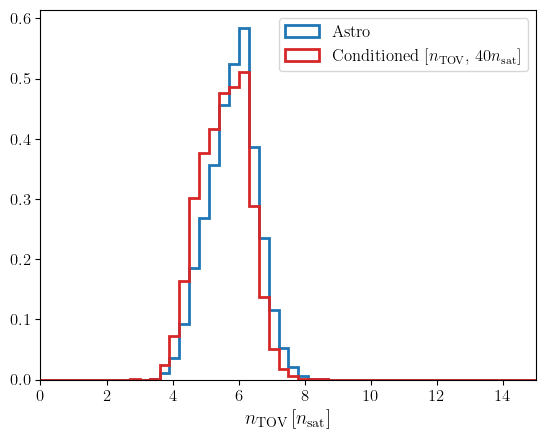

In [5]:
fig, ax = plt.subplots()

hist_kwargs = dict(
    range=(0,15),
    bins=50,
    histtype='step',
    density=True,
    linewidth=2
)

ax.hist(ntov_array/nsat, weights=astro_weights, color='C0', label='Astro', **hist_kwargs)

ax.hist(ntov_array/nsat, weights=astro_weights*pqcd_cond_weights, color='C3', label='Conditioned [$n_\mathrm{TOV}$, $40n_\mathrm{sat}$]', **hist_kwargs)

ax.legend()

ax.set_xlim(0, 15)

_ = ax.set_xlabel(r'$n_{\rm TOV}\, [n_{\rm sat}]$')

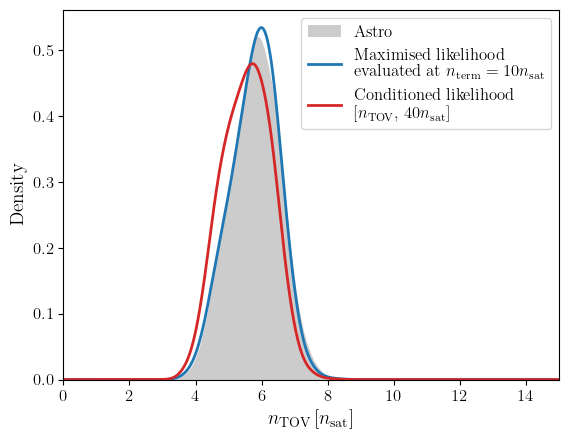

In [6]:
astro_kde = gaussian_kde(ntov_array/nsat, weights=astro_weights, bw_method=0.2)
pqcd_max_kde = gaussian_kde(ntov_array/nsat, weights=astro_weights*pqcd_max_weights, bw_method=0.3)
pqcd_cond_kde = gaussian_kde(ntov_array/nsat, weights=astro_weights*pqcd_cond_weights, bw_method=0.3)

ntov_linspace = np.linspace(0, 15, 1000)

fig, ax = plt.subplots()

kde_kwargs = dict(
    linewidth=2
)

ax.fill_between(ntov_linspace, 0, astro_kde(ntov_linspace), color='k', alpha=0.2, label='Astro', linewidth=0)
ax.plot(ntov_linspace, pqcd_max_kde(ntov_linspace), color='C0', label='Maximised likelihood \nevaluated at $n_\mathrm{term} = 10n_\mathrm{sat}$', **kde_kwargs)
ax.plot(ntov_linspace, pqcd_cond_kde(ntov_linspace), color='C3', label='Conditioned likelihood \n[$n_\mathrm{TOV}$, $40n_\mathrm{sat}$]', **kde_kwargs)

ax.legend()

ax.set_xlim(0, 15)
ax.set_ylim(0)

ax.set_xlabel(r'$n_{\rm TOV}\, [n_{\rm sat}]$')
ax.set_ylabel('Density')

fig.savefig('figures/quantities_at_ntov/ntov_posterior.pdf', bbox_inches='tight')

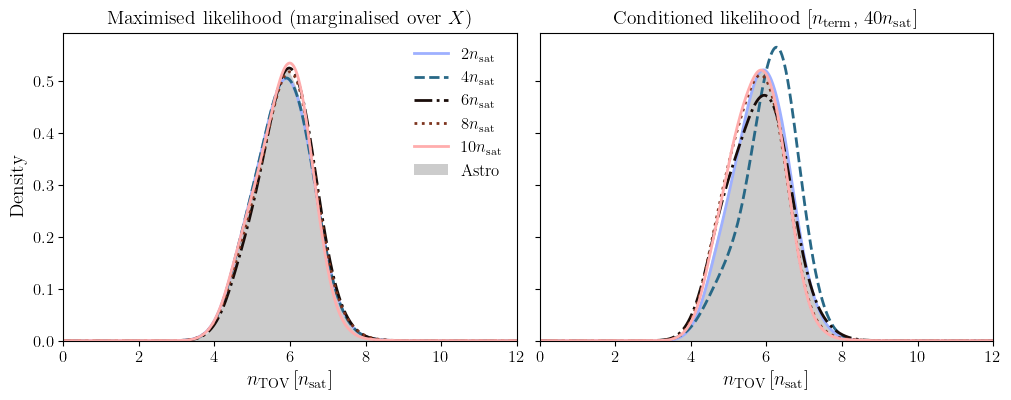

In [7]:
astro_kde = gaussian_kde(ntov_array/nsat, weights=astro_weights, bw_method=0.2)

nterm_list = [2,4,6,8,10]
linestyles = ['-', '--', '-.', ':']
methods = ['Xmarg', 'marg']
titles = ['Maximised likelihood (marginalised over $X$)', 'Conditioned likelihood [$n_\mathrm{term}$, $40n_\mathrm{sat}$]']

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

fig.subplots_adjust(wspace=0.05)

for ax, method in zip(axs, methods):

    ax.set_title(titles[methods.index(method)])

    ax.fill_between(ntov_linspace, 0, astro_kde(ntov_linspace), color='k', alpha=0.2, label='Astro', linewidth=0)

    for i, nterm in enumerate(nterm_list):

        nterm_weights = np.loadtxt(f'../data/weights/qcd_weights_{nterm:02}nsat_{method}.dat')

        kde = gaussian_kde(ntov_array/nsat, weights=astro_weights*nterm_weights, bw_method=0.3)

        ax.plot(ntov_linspace, kde(ntov_linspace), color=to_hex(cm.berlin(i/(len(nterm_list)-1))), linestyle=linestyles[i%4], linewidth=2, label=f'${nterm}n_\mathrm{{sat}}$')
        
    ax.set_xlim(0, 12)
    # ax.set_ylim(0)

    ax.set_xlabel(r'$n_{\rm TOV}\, [n_{\rm sat}]$')

ylim = axs[0].get_ylim()

axs[0].set_ylim(0, ylim[1])

axs[0].set_ylabel('Density')

contours = [
    Line2D([0], [0], color=to_hex(cm.berlin(i/(len(nterm_list)-1))), linestyle=linestyles[i%4], linewidth=2) for i in range(len(nterm_list))
    ]
filled_contours = [mpatches.Patch(color='k', alpha=0.2, linewidth=0)]

l1 = axs[0].legend(
    contours + filled_contours,
    [f'${nterm}n_\mathrm{{sat}}$' for nterm in nterm_list] + ['Astro'],
    loc='upper right',
    ncol=1,
    frameon=False
)

fig.savefig('figures/quantities_at_ntov/ntov_posterior_comparison.pdf', bbox_inches='tight')